# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 3, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_56_drop0.25e500b512_custom/lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_56_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_56_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 216
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '015', '020', '021', '022', '023', '024', '025', '030', '031', '032', '033', '034', '035', '040', '041', '042', '043', '044', '045', '050', '051', '052', '053', '054', '055', '100', '101', '102', '103', '104', '105', '110', '111', '112', '113', '114', '115', '120', '121', '122', '123', '124', '125', '130', '131', '132', '133', '134', '135', '140', '141', '142', '143', '144', '145', '150', '151', '152', '153', '154', '155', '200', '201', '202', '203', '204', '205', '210', '211', '212', '213', '214', '215', '220', '221', '222', '223', '224', '225', '230', '231', '232', '233', '234', '235', '240', '241', '242', '243', '244', '245', '250', '251', '252', '253', '254', '255', '300', '301', '302', '303', '304', '305', '310', '311', '312', '313', '314', '315', '320', '321', '322', '323', '324', '325', '330', '331', '33

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 56
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '020', '021', '022', '023', '030', '031', '032', '040', '041', '050', '100', '101', '102', '103', '104', '110', '111', '112', '113', '120', '121', '122', '130', '131', '140', '200', '201', '202', '203', '210', '211', '212', '220', '221', '230', '300', '301', '302', '310', '311', '320', '400', '401', '410', '500']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  5.2min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 1570)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 1570)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 1570)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 50 Complete [00h 18m 23s]
val_loss: 0.11880824714899063

Best val_loss So Far: 0.11880824714899063
Total elapsed time: 08h 10m 41s
Epoch 1/500
254/254 [==============================] - 11s 44ms/step - loss: 0.4143 - val_loss: 0.2568
Epoch 2/500
254/254 [==============================] - 10s 40ms/step - loss: 0.2941 - val_loss: 0.2187
Epoch 3/500
254/254 [==============================] - 10s 40ms/step - loss: 0.2647 - val_loss: 0.2016
Epoch 4/500
254/254 [==============================] - 10s 41ms/step - loss: 0.2479 - val_loss: 0.1864
Epoch 5/500
254/254 [==============================] - 11s 41ms/step - loss: 0.2391 - val_loss: 0.1795
Epoch 6/500
254/254 [==============================] - 11s 42ms/step - loss: 0.2305 - val_loss: 0.1717
Epoch 7/500
254/254 [==============================] - 10s 41ms/step - loss: 0.2258 - val_loss: 0.1708
Epoch 8/500
254/254 [==============================] - 11s 42ms/step - loss: 0.2210 - val_loss: 0.1624
Epoch 9/500
254/254 [==================

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 40ms/step - loss: 0.1862 - val_loss: 0.1414
Epoch 31/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1871 - val_loss: 0.1318
Epoch 32/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1858 - val_loss: 0.1355
Epoch 33/500
254/254 [==============================] - 11s 41ms/step - loss: 0.1856 - val_loss: 0.1325
Epoch 34/500
254/254 [==============================] - 11s 42ms/step - loss: 0.1850 - val_loss: 0.1336
Epoch 35/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1837 - val_loss: 0.1276
Epoch 36/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1844 - val_loss: 0.1360
Epoch 37/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1843 - val_loss: 0.1409
Epoch 38/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1831 - val_loss: 0.1354
Epoch 39/500
254/254 [==============================] - 10s 38ms/step - loss:

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 11s 41ms/step - loss: 0.1738 - val_loss: 0.1239
Epoch 79/500
254/254 [==============================] - 11s 41ms/step - loss: 0.1741 - val_loss: 0.1224
Epoch 80/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1734 - val_loss: 0.1246
Epoch 81/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1751 - val_loss: 0.1205
Epoch 82/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1733 - val_loss: 0.1254
Epoch 83/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1736 - val_loss: 0.1311
Epoch 84/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1742 - val_loss: 0.1212
Epoch 85/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1724 - val_loss: 0.1211
Epoch 86/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1728 - val_loss: 0.1225
Epoch 87/500
254/254 [==============================] - 10s 41ms/step - loss:

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 38ms/step - loss: 0.1686 - val_loss: 0.1256
Epoch 145/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1690 - val_loss: 0.1222
Epoch 146/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1685 - val_loss: 0.1179
Epoch 147/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1683 - val_loss: 0.1189
Epoch 148/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1687 - val_loss: 0.1207
Epoch 149/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1679 - val_loss: 0.1175
Epoch 150/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1678 - val_loss: 0.1217
Epoch 151/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1681 - val_loss: 0.1251
Epoch 152/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1685 - val_loss: 0.1200
Epoch 153/500
254/254 [==============================] - 10s 38ms/step -

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 38ms/step - loss: 0.1663 - val_loss: 0.1232
Epoch 192/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1654 - val_loss: 0.1144
Epoch 193/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1659 - val_loss: 0.1255
Epoch 194/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1669 - val_loss: 0.1207
Epoch 195/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1650 - val_loss: 0.1193
Epoch 196/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1644 - val_loss: 0.1163
Epoch 197/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1652 - val_loss: 0.1309
Epoch 198/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1640 - val_loss: 0.1170
Epoch 199/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1663 - val_loss: 0.1240
Epoch 200/500
254/254 [==============================] - 10s 38ms/ste

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 40ms/step - loss: 0.1654 - val_loss: 0.1216
Epoch 236/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1643 - val_loss: 0.1140
Epoch 237/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1655 - val_loss: 0.1156
Epoch 238/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1654 - val_loss: 0.1191
Epoch 239/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1646 - val_loss: 0.1216
Epoch 240/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1641 - val_loss: 0.1183
Epoch 241/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1648 - val_loss: 0.1164
Epoch 242/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1648 - val_loss: 0.1204
Epoch 243/500
254/254 [==============================] - 11s 42ms/step - loss: 0.1652 - val_loss: 0.1133
Epoch 244/500
254/254 [==============================] - 10s 40ms/ste

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 40ms/step - loss: 0.1633 - val_loss: 0.1158
Epoch 283/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1632 - val_loss: 0.1158
Epoch 284/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1639 - val_loss: 0.1198
Epoch 285/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1636 - val_loss: 0.1154
Epoch 286/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1639 - val_loss: 0.1179
Epoch 287/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1634 - val_loss: 0.1169
Epoch 288/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1622 - val_loss: 0.1194
Epoch 289/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1632 - val_loss: 0.1191
Epoch 290/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1638 - val_loss: 0.1225
Epoch 291/500
254/254 [==============================] - 10s 40ms/ste

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 40ms/step - loss: 0.1621 - val_loss: 0.1278
Epoch 352/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1639 - val_loss: 0.1206
Epoch 353/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1631 - val_loss: 0.1280
Epoch 354/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1614 - val_loss: 0.1201
Epoch 355/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1624 - val_loss: 0.1216
Epoch 356/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1620 - val_loss: 0.1146
Epoch 357/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1615 - val_loss: 0.1257
Epoch 358/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1620 - val_loss: 0.1170
Epoch 359/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1623 - val_loss: 0.1166
Epoch 360/500
254/254 [==============================] - 10s 41ms/ste

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 40ms/step - loss: 0.1631 - val_loss: 0.1183
Epoch 397/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1630 - val_loss: 0.1219
Epoch 398/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1622 - val_loss: 0.1170
Epoch 399/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1619 - val_loss: 0.1169
Epoch 400/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1622 - val_loss: 0.1210
Epoch 401/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1622 - val_loss: 0.1295
Epoch 402/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1621 - val_loss: 0.1185
Epoch 403/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1620 - val_loss: 0.1219
Epoch 404/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1622 - val_loss: 0.1260
Epoch 405/500
254/254 [==============================] - 10s 41ms/ste

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 9s 36ms/step - loss: 0.1602 - val_loss: 0.1212
Epoch 441/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1614 - val_loss: 0.1250
Epoch 442/500
254/254 [==============================] - 9s 36ms/step - loss: 0.1613 - val_loss: 0.1262
Epoch 443/500
254/254 [==============================] - 9s 36ms/step - loss: 0.1614 - val_loss: 0.1150
Epoch 444/500
254/254 [==============================] - 9s 36ms/step - loss: 0.1615 - val_loss: 0.1177
Epoch 445/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1626 - val_loss: 0.1268
Epoch 446/500
254/254 [==============================] - 10s 38ms/step - loss: 0.1615 - val_loss: 0.1224
Epoch 447/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1604 - val_loss: 0.1180
Epoch 448/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1616 - val_loss: 0.1179
Epoch 449/500
254/254 [==============================] - 9s 36ms/step - loss:

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 10s 39ms/step - loss: 0.1605 - val_loss: 0.1233
Epoch 486/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1604 - val_loss: 0.1144
Epoch 487/500
254/254 [==============================] - 10s 41ms/step - loss: 0.1609 - val_loss: 0.1243
Epoch 488/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1601 - val_loss: 0.1167
Epoch 489/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1610 - val_loss: 0.1131
Epoch 490/500
254/254 [==============================] - 9s 37ms/step - loss: 0.1606 - val_loss: 0.1318
Epoch 491/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1609 - val_loss: 0.1204
Epoch 492/500
254/254 [==============================] - 10s 40ms/step - loss: 0.1598 - val_loss: 0.1249
Epoch 493/500
254/254 [==============================] - 10s 39ms/step - loss: 0.1616 - val_loss: 0.1156
Epoch 494/500
254/254 [==============================] - 10s 40ms/step

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 592.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 592.1min finished


## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.25
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 128
Score: 0.11880824714899063
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.25
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 1024
Score: 0.11917325854301453
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.25
optimizer: adam_weight_decay
learning_rate: 0.0001
dense_block_1/units_2: 1024
Score: 0.11997349560260773
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_b

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1401)]            0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 1401)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1435648   
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1457)             

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.446,0.534,19.628,0.062,0.000,0.129,0.171,0.736,0.920,0.190,0.545,0.144,-0.037,0.019,1.317,1.351
inetPoly_VS_targetPoly_test,0.445,0.533,30.073,0.065,0.000,0.125,0.166,1.603,0.928,0.182,0.556,0.141,-0.033,0.015,1.318,1.349
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.124,0.161,0.727,0.930,0.183,0.422,0.133,-0.037,0.018,1.317,1.342
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.121,0.156,1.626,0.937,0.175,0.424,0.130,-0.033,0.015,1.318,1.341
inetPoly_VS_lstsqTarget_valid,3.507,5.172,126.200,0.018,0.000,0.124,0.161,0.727,0.930,0.183,0.427,0.132,-0.037,0.018,1.317,1.342
inetPoly_VS_lstsqTarget_test,3.526,5.218,129.289,0.017,0.000,0.121,0.156,1.582,0.938,0.175,0.429,0.129,-0.033,0.015,1.318,1.341
inetPoly_VS_lstsqLambda_valid,3.507,5.172,126.200,0.018,0.000,0.124,0.161,0.727,0.930,0.183,0.427,0.132,-0.037,0.018,1.317,1.342
inetPoly_VS_lstsqLambda_test,3.526,5.218,129.289,0.017,0.000,0.121,0.156,1.582,0.938,0.175,0.429,0.129,-0.033,0.015,1.318,1.341
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.012,0.016,0.761,0.999,0.017,0.093,0.016,0.018,0.018,1.342,1.342
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.012,0.017,0.137,0.999,0.016,0.093,0.017,0.015,0.015,1.341,1.341


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.195,0.111,0.223,0.114,0.061,0.139,0.308,0.084,0.186,0.108,0.107,0.129,0.088,0.108,0.142,0.059,0.266,0.149,0.087,0.052,0.127,0.091,0.137,0.155,0.146,0.134,0.084,0.245,0.098,0.107,0.091,0.124,0.229,0.170,0.102,0.143,0.170,0.173,0.076,0.106,0.119,0.054,0.146,0.115,0.091,0.122,0.171,0.061,0.111,0.211,0.110,0.104,0.117,0.099,0.090,0.175,0.071,0.138,0.198,0.214,0.118,0.132,0.094,0.167,0.102,0.156,0.113,0.103,0.084,0.124,0.156,0.097,0.263,0.125,0.143,0.071,0.099,0.099,0.144,0.059,0.083,0.248,0.099,0.183,0.118,0.136,0.082,0.151,0.150,0.096,0.106,0.124,0.067,0.088,0.112,0.120,0.162,0.115,0.101,0.088,0.119,0.105,0.073,0.191,0.054,0.234,0.118,0.091,0.122,0.078,0.097,0.129,0.098,0.103,0.092,0.151,0.092,0.182,0.082,0.131,0.205,0.293,0.107,0.210,0.154,0.181,0.141,0.137,0.089,0.227,0.083,0.122,0.118,0.098,0.175,0.113,0.084,0.239,0.105,0.118,0.110,0.215,0.075,0.098,0.123,0.128,0.139,0.146,0.300,0.120,0.098,0.147,0.097,0.133,0.114,0.139,0.079,0.167,0.097,0.091,0.165,0.145,0.175,0.139,0.190,0.101,0.106,0.170,0.126,0.144,0.195,0.084,0.143,0.089,0.151,0.128,0.113,0.204,0.091,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.921,0.947,0.926,0.706,0.913,0.834,0.959,0.978,0.936,0.980,0.961,0.815,0.971,0.930,0.967,0.982,0.436,0.965,0.782,0.986,0.925,0.927,0.941,0.963,0.905,0.964,0.950,0.929,0.978,0.961,0.977,0.975,0.921,0.880,0.962,0.746,0.968,0.936,0.995,0.970,0.971,0.991,0.972,0.936,0.935,0.684,0.942,0.888,0.965,0.607,0.918,0.965,0.951,0.944,0.905,0.929,0.964,0.941,0.932,0.841,0.872,0.917,0.977,0.975,0.971,0.984,0.921,0.956,0.927,0.356,0.905,0.985,0.909,0.859,0.952,0.958,0.876,0.982,0.931,0.988,0.902,0.909,0.768,0.965,0.965,0.971,0.972,0.826,0.785,0.958,0.879,0.969,0.973,0.979,0.907,0.928,0.951,0.979,0.958,0.970,0.935,0.929,0.872,0.947,0.989,0.955,0.978,0.974,0.972,0.985,0.956,0.944,0.960,0.976,0.904,0.418,0.905,0.935,0.927,0.910,0.920,0.891,0.921,0.947,0.774,0.931,0.967,0.607,0.972,0.896,0.939,0.897,0.939,0.955,0.938,0.885,0.974,0.532,0.935,0.975,0.966,0.927,0.977,0.984,0.832,0.781,0.883,0.971,0.592,0.973,0.963,0.974,0.886,0.931,0.985,0.937,0.965,0.878,0.978,0.915,0.954,0.968,0.963,0.959,0.977,0.974,0.955,0.969,0.963,0.894,0.881,0.974,0.918,0.983,0.860,0.899,0.674,0.947,0.943,-0

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.9160337679149697


0.630364120006561*a**1.0*b**1.0*c**1.0 + 0.42106556892395*a**1.0*b**1.0*c**2.0 + 0.0315217897295952*a**1.0*b**1.0*c**3.0 + 0.293891876935959*a**1.0*b**1.0 + 0.523999989032745*a**1.0*b**2.0*c**1.0 + 0.071187824010849*a**1.0*b**2.0*c**2.0 + 0.183890387415886*a**1.0*b**2.0 - 0.0661095306277275*a**1.0*b**3.0*c**1.0 + 0.260873585939407*a**1.0*b**3.0 + 0.0281988903880119*a**1.0*b**4.0 + 0.427195310592651*a**1.0*c**1.0 + 0.234777361154556*a**1.0*c**2.0 - 0.124726936221123*a**1.0*c**3.0 - 0.271301209926605*a**1.0*c**4.0 + 0.157710060477257*a**1.0 + 0.417125433683395*a**2.0*b**1.0*c**1.0 + 0.0212816148996353*a**2.0*b**1.0*c**2.0 + 0.264418482780457*a**2.0*b**1.0 + 0.0739234909415245*a**2.0*b**2.0*c**1.0 + 0.0633174255490303*a**2.0*b**2.0 - 0.0759875327348709*a**2.0*b**3.0 + 0.381203353404999*a**2.0*c**1.0 + 0.161172330379486*a**2.0*c**2.0 - 0.0130358189344406*a**2.0*c**3.0 - 0.495126664638519*a**2.0 - 0.171939641237259*a**3.0*b**1.0*c**1.0 + 0.37691342830658*a**3.0*b**1.0 + 0.254687815904617*a*

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9911986766587807


-2.15408063048723*a**1.0*b**1.0*c**1.0 + 5.59383671053866*a**1.0*b**1.0*c**2.0 - 5.24536016330512*a**1.0*b**1.0*c**3.0 + 1.21393732742534*a**1.0*b**1.0 + 2.69728803278176*a**1.0*b**2.0*c**1.0 + 2.71899552159242*a**1.0*b**2.0*c**2.0 - 2.91747585484195*a**1.0*b**2.0 - 4.66383896473223*a**1.0*b**3.0*c**1.0 + 6.28363250760711*a**1.0*b**3.0 - 2.45001927955096*a**1.0*b**4.0 + 1.78045014607457*a**1.0*c**1.0 - 0.848691489795735*a**1.0*c**2.0 + 4.86529365104933*a**1.0*c**3.0 - 3.0295720118915*a**1.0*c**4.0 - 0.231654005810646*a**1.0 + 3.70990637348044*a**2.0*b**1.0*c**1.0 + 1.92787982042031*a**2.0*b**1.0*c**2.0 + 0.101148170447844*a**2.0*b**1.0 + 1.74242073791843*a**2.0*b**2.0*c**1.0 - 5.24789231757665*a**2.0*b**2.0 + 0.0890206466491945*a**2.0*b**3.0 - 2.56525149853975*a**2.0*c**1.0 - 7.78705225523386*a**2.0*c**2.0 + 2.20366529271046*a**2.0*c**3.0 + 1.69665745457718*a**2.0 - 3.52551497104444*a**3.0*b**1.0*c**1.0 + 3.60459285759467*a**3.0*b**1.0 + 3.15120335967842*a**3.0*b**2.0 + 8.1525411946556

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.964382500662779*a**1.0*b**1.0*c**1.0 + 0.491023701988645*a**1.0*b**1.0*c**2.0 + 0.707375313869067*a**1.0*b**1.0*c**3.0 + 0.481248045950776*a**1.0*b**1.0 + 0.311940938274469*a**1.0*b**2.0*c**1.0 + 0.376164455184542*a**1.0*b**2.0*c**2.0 - 0.288726612719165*a**1.0*b**2.0 + 0.257630069373177*a**1.0*b**3.0*c**1.0 - 0.609746964528616*a**1.0*b**3.0 - 0.0205276341709264*a**1.0*b**4.0 + 0.2201385906815*a**1.0*c**1.0 + 0.735813474992925*a**1.0*c**2.0 + 0.43282627689881*a**1.0*c**3.0 - 0.951634108156304*a**1.0*c**4.0 + 0.504433971237086*a**1.0 - 0.514054484688746*a**2.0*b**1.0*c**1.0 + 0.956739871888895*a**2.0*b**1.0*c**2.0 + 0.8350006725254*a**2.0*b**1.0 + 0.587405732866145*a**2.0*b**2.0*c**1.0 + 0.283084556936419*a**2.0*b**2.0 + 0.0929295130362326*a**2.0*b**3.0 + 0.28652752709412*a**2.0*c**1.0 - 0.131397973100214*a**2.0*c**2.0 - 0.606208127921177*a**2.0*c**3.0 - 0.646563966568509*a**2.0 + 0.948809723978787*a**3.0*b**1.0*c**1.0 + 0.0184011410727014*a**3.0*b**1.0 - 0.217797914697204*a**3.0*b**2

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.961353388794695


-0.372790962457657*a**1.0*b**1.0*c**1.0 - 0.356390923261642*a**1.0*b**1.0*c**2.0 - 0.13894347846508*a**1.0*b**1.0*c**3.0 - 0.227795407176018*a**1.0*b**1.0 - 0.256556242704391*a**1.0*b**2.0*c**1.0 + 0.0485112555325031*a**1.0*b**2.0*c**2.0 - 0.456828415393829*a**1.0*b**2.0 - 0.123487591743469*a**1.0*b**3.0*c**1.0 - 0.216873988509178*a**1.0*b**3.0 + 0.0022547016851604*a**1.0*b**4.0 - 0.342405289411545*a**1.0*c**1.0 - 0.416680008172989*a**1.0*c**2.0 + 0.00469955103471875*a**1.0*c**3.0 - 0.0810281708836555*a**1.0*c**4.0 - 0.00786029547452927*a**1.0 - 0.389635980129242*a**2.0*b**1.0*c**1.0 + 0.0384985841810703*a**2.0*b**1.0*c**2.0 - 0.381007999181747*a**2.0*b**1.0 + 0.186839014291763*a**2.0*b**2.0*c**1.0 - 0.265042275190353*a**2.0*b**2.0 - 0.0959130078554153*a**2.0*b**3.0 - 0.460566520690918*a**2.0*c**1.0 - 0.386276215314865*a**2.0*c**2.0 - 0.275144457817078*a**2.0*c**3.0 - 0.20843942463398*a**2.0 - 0.251525789499283*a**3.0*b**1.0*c**1.0 - 0.187779381871223*a**3.0*b**1.0 + 0.0471051931381226

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9997101074336114


2.17395156717037*a**1.0*b**1.0*c**1.0 - 0.732352507193982*a**1.0*b**1.0*c**2.0 - 0.799897843514205*a**1.0*b**1.0*c**3.0 - 2.98653217157915*a**1.0*b**1.0 - 1.02971501743842*a**1.0*b**2.0*c**1.0 + 1.07116318976797*a**1.0*b**2.0*c**2.0 + 3.06007476349571*a**1.0*b**2.0 - 0.599729019539482*a**1.0*b**3.0*c**1.0 - 3.11232616534746*a**1.0*b**3.0 + 1.75673893762539*a**1.0*b**4.0 - 4.08254562545062*a**1.0*c**1.0 + 5.03484777289457*a**1.0*c**2.0 - 3.613615290278*a**1.0*c**3.0 + 1.73568256951696*a**1.0*c**4.0 + 0.75438202635528*a**1.0 - 2.90499398452994*a**2.0*b**1.0*c**1.0 + 0.184029067239541*a**2.0*b**1.0*c**2.0 + 6.50873465739602*a**2.0*b**1.0 + 0.901042077664878*a**2.0*b**2.0*c**1.0 - 5.62493250968841*a**2.0*b**2.0 + 0.445650897786241*a**2.0*b**3.0 + 9.14877473990152*a**2.0*c**1.0 - 8.83418693924905*a**2.0*c**2.0 + 1.20979130614268*a**2.0*c**3.0 - 5.1516003010053*a**2.0 + 1.37851127532573*a**3.0*b**1.0*c**1.0 - 6.47976457316049*a**3.0*b**1.0 + 3.22539993229951*a**3.0*b**2.0 - 9.60842891723451*

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.298031846183705*a**1.0*b**1.0*c**1.0 + 0.152513636713778*a**1.0*b**1.0*c**2.0 - 0.188013191476831*a**1.0*b**1.0*c**3.0 - 0.820099304875413*a**1.0*b**1.0 + 0.654556574846981*a**1.0*b**2.0*c**1.0 - 0.599396994112515*a**1.0*b**2.0*c**2.0 - 0.480713593052276*a**1.0*b**2.0 - 0.293921521177644*a**1.0*b**3.0*c**1.0 + 0.139139995413444*a**1.0*b**3.0 - 0.320363034810101*a**1.0*b**4.0 - 0.38993493173754*a**1.0*c**1.0 - 0.341945460133901*a**1.0*c**2.0 + 0.29279547831831*a**1.0*c**3.0 + 0.37702492400793*a**1.0*c**4.0 - 0.260243944297626*a**1.0 - 0.462420339226466*a**2.0*b**1.0*c**1.0 - 0.594866400411707*a**2.0*b**1.0*c**2.0 + 0.650407505921268*a**2.0*b**1.0 - 0.224873941321708*a**2.0*b**2.0*c**1.0 - 0.710439611907886*a**2.0*b**2.0 + 0.548497514182053*a**2.0*b**3.0 - 0.542227225927393*a**2.0*c**1.0 - 0.965879657915519*a**2.0*c**2.0 - 0.693678862685854*a**2.0*c**3.0 - 0.627163100278539*a**2.0 + 0.84409511991959*a**3.0*b**1.0*c**1.0 - 0.892210605843251*a**3.0*b**1.0 - 0.296267357764728*a**3.0*b**2.

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.9280657145641366 (1000 Samples)
Mean (only positive): 0.9280657145641366 (1000 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9963051971436372 (1000 Samples)
Mean (only positive): 0.9963051971436372 (1000 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

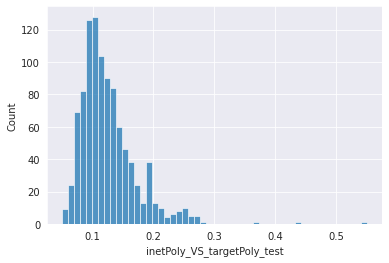

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

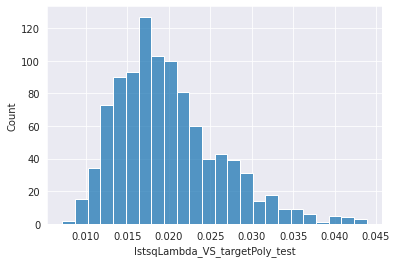

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

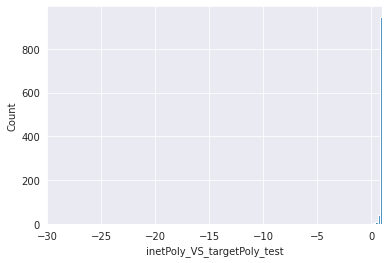

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

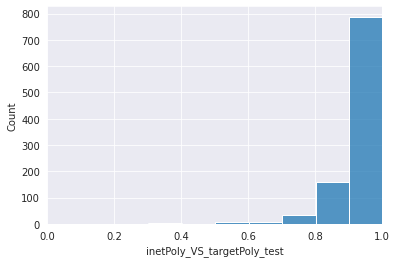

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

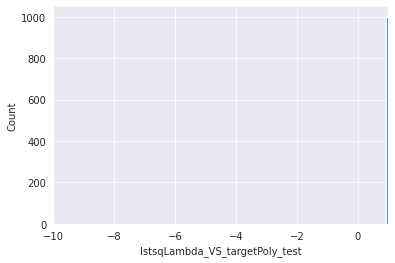

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

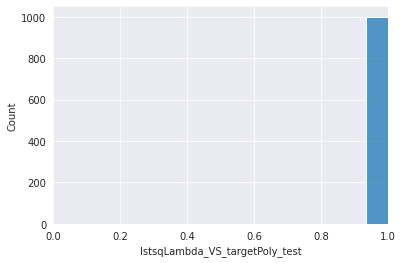

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.2766*a**1.0*b**1.0*c**1.0 - 0.551*a**1.0*b**1.0*c**2.0 - 0.6562*a**1.0*b**1.0*c**3.0 + 0.2147*a**1.0*b**1.0 - 0.4148*a**1.0*b**2.0*c**1.0 + 0.0775*a**1.0*b**2.0*c**2.0 - 0.3452*a**1.0*b**2.0 + 0.7482*a**1.0*b**3.0*c**1.0 + 0.0031*a**1.0*b**3.0 - 0.2946*a**1.0*b**4.0 + 0.02*a**1.0*c**1.0 - 0.1999*a**1.0*c**2.0 + 0.6372*a**1.0*c**3.0 + 0.651*a**1.0*c**4.0 - 0.7997*a**1.0 - 0.2891*a**2.0*b**1.0*c**1.0 - 0.0084*a**2.0*b**1.0*c**2.0 - 0.0879*a**2.0*b**1.0 - 0.0743*a**2.0*b**2.0*c**1.0 + 0.9381*a**2.0*b**2.0 - 0.1577*a**2.0*b**3.0 - 0.4365*a**2.0*c**1.0 + 0.2178*a**2.0*c**2.0 - 0.0067*a**2.0*c**3.0 - 0.7931*a**2.0 - 0.4225*a**3.0*b**1.0*c**1.0 + 0.0696*a**3.0*b**1.0 + 0.5774*a**3.0*b**2.0 + 0.2893*a**3.0*c**1.0 + 0.2689*a**3.0*c**2.0 + 0.6333*a**3.0 - 0.8599*a**4.0*b**1.0 - 0.0115*a**4.0*c**1.0 - 0.7781*a**4.0 - 0.5091*a**5.0 - 0.3278*b**1.0*c**1.0 - 0.8931*b**1.0*c**2.0 + 0.9612*b**1.0*c**3.0 + 0.5858*b**1.0*c**4.0 + 0.9776*b**1.0 - 0.2513*b**2.0*c**1.0 + 0.5147*b**2.0*c**2.0 + 0.739*b**

LSTSQ Target Poly:


1.3436*a**1.0*b**1.0*c**1.0 - 3.6354*a**1.0*b**1.0*c**2.0 + 0.9149*a**1.0*b**1.0*c**3.0 - 0.9677*a**1.0*b**1.0 - 1.0305*a**1.0*b**2.0*c**1.0 - 0.6831*a**1.0*b**2.0*c**2.0 + 1.753*a**1.0*b**2.0 + 3.0912*a**1.0*b**3.0*c**1.0 - 2.4315*a**1.0*b**3.0 + 0.2178*a**1.0*b**4.0 + 0.836*a**1.0*c**1.0 - 2.3639*a**1.0*c**2.0 + 5.2689*a**1.0*c**3.0 - 2.1634*a**1.0*c**4.0 - 0.4952*a**1.0 - 2.2203*a**2.0*b**1.0*c**1.0 + 1.4844*a**2.0*b**1.0*c**2.0 + 1.5798*a**2.0*b**1.0 - 1.6115*a**2.0*b**2.0*c**1.0 + 1.2028*a**2.0*b**2.0 + 0.0951*a**2.0*b**3.0 - 3.7543*a**2.0*c**1.0 + 2.2428*a**2.0*c**2.0 - 0.4471*a**2.0*c**3.0 - 2.6063*a**2.0 + 1.1805*a**3.0*b**1.0*c**1.0 - 1.9608*a**3.0*b**1.0 + 0.1206*a**3.0*b**2.0 + 4.7769*a**3.0*c**1.0 - 1.5567*a**3.0*c**2.0 + 6.1726*a**3.0 + 0.128*a**4.0*b**1.0 - 1.6886*a**4.0*c**1.0 - 7.9181*a**4.0 + 2.6409*a**5.0 + 3.0488*b**1.0*c**1.0 - 6.7649*b**1.0*c**2.0 + 7.8375*b**1.0*c**3.0 - 2.8285*b**1.0*c**4.0 - 0.0213*b**1.0 - 8.2998*b**2.0*c**1.0 + 6.7261*b**2.0*c**2.0 - 0.6149*b*

LSTSQ Lambda Poly:


1.3436*a**1.0*b**1.0*c**1.0 - 3.6354*a**1.0*b**1.0*c**2.0 + 0.9149*a**1.0*b**1.0*c**3.0 - 0.9677*a**1.0*b**1.0 - 1.0305*a**1.0*b**2.0*c**1.0 - 0.6831*a**1.0*b**2.0*c**2.0 + 1.753*a**1.0*b**2.0 + 3.0912*a**1.0*b**3.0*c**1.0 - 2.4315*a**1.0*b**3.0 + 0.2178*a**1.0*b**4.0 + 0.836*a**1.0*c**1.0 - 2.3639*a**1.0*c**2.0 + 5.2689*a**1.0*c**3.0 - 2.1634*a**1.0*c**4.0 - 0.4952*a**1.0 - 2.2203*a**2.0*b**1.0*c**1.0 + 1.4844*a**2.0*b**1.0*c**2.0 + 1.5798*a**2.0*b**1.0 - 1.6115*a**2.0*b**2.0*c**1.0 + 1.2028*a**2.0*b**2.0 + 0.0951*a**2.0*b**3.0 - 3.7543*a**2.0*c**1.0 + 2.2428*a**2.0*c**2.0 - 0.4471*a**2.0*c**3.0 - 2.6063*a**2.0 + 1.1805*a**3.0*b**1.0*c**1.0 - 1.9608*a**3.0*b**1.0 + 0.1206*a**3.0*b**2.0 + 4.7769*a**3.0*c**1.0 - 1.5567*a**3.0*c**2.0 + 6.1726*a**3.0 + 0.128*a**4.0*b**1.0 - 1.6886*a**4.0*c**1.0 - 7.9181*a**4.0 + 2.6409*a**5.0 + 3.0488*b**1.0*c**1.0 - 6.7649*b**1.0*c**2.0 + 7.8375*b**1.0*c**3.0 - 2.8285*b**1.0*c**4.0 - 0.0213*b**1.0 - 8.2998*b**2.0*c**1.0 + 6.7261*b**2.0*c**2.0 - 0.6149*b*

I-Net Poly:


-0.326700001955032*a**1.0*b**1.0*c**1.0 - 0.107900001108646*a**1.0*b**1.0*c**2.0 + 0.0238000005483627*a**1.0*b**1.0*c**3.0 - 0.1233000010252*a**1.0*b**1.0 - 0.206400007009506*a**1.0*b**2.0*c**1.0 - 0.143900007009506*a**1.0*b**2.0*c**2.0 - 0.221900001168251*a**1.0*b**2.0 - 0.0816000029444695*a**1.0*b**3.0*c**1.0 + 0.0223999992012978*a**1.0*b**3.0 + 0.128299996256828*a**1.0*b**4.0 - 0.149900004267693*a**1.0*c**1.0 + 0.00260000000707805*a**1.0*c**2.0 + 0.309700012207031*a**1.0*c**3.0 + 0.160400003194809*a**1.0*c**4.0 - 0.43979999423027*a**1.0 - 0.18529999256134*a**2.0*b**1.0*c**1.0 + 0.237100005149841*a**2.0*b**1.0*c**2.0 - 0.118199996650219*a**2.0*b**1.0 - 0.101999998092651*a**2.0*b**2.0*c**1.0 - 0.0263000000268221*a**2.0*b**2.0 + 0.0502999983727932*a**2.0*b**3.0 + 0.0214000009000301*a**2.0*c**1.0 + 0.0553000010550022*a**2.0*c**2.0 + 0.181400001049042*a**2.0*c**3.0 - 0.411399990320206*a**2.0 - 0.29899999499321*a**3.0*b**1.0*c**1.0 - 0.170900002121925*a**3.0*b**1.0 + 0.0148999998345971*a*

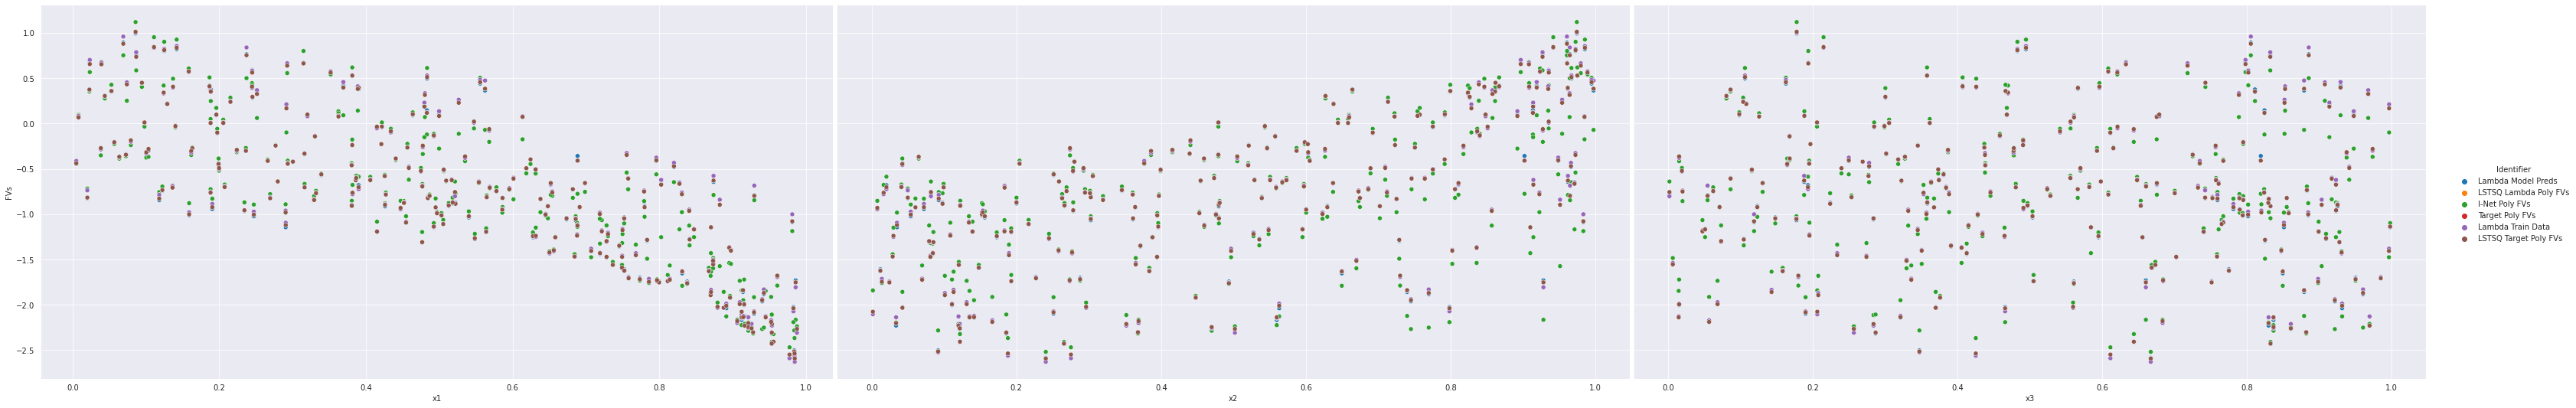

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.009423457834881991 | 0.999800893923566  |   -    |           1.3436*a**1.0*b**1.0*c**1.0 -            |
|            vs.            |                      |                    |        |           3.6354*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.9149*a**1.0*b**1.0*c**3.0 - 0.9677*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 1.0305*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

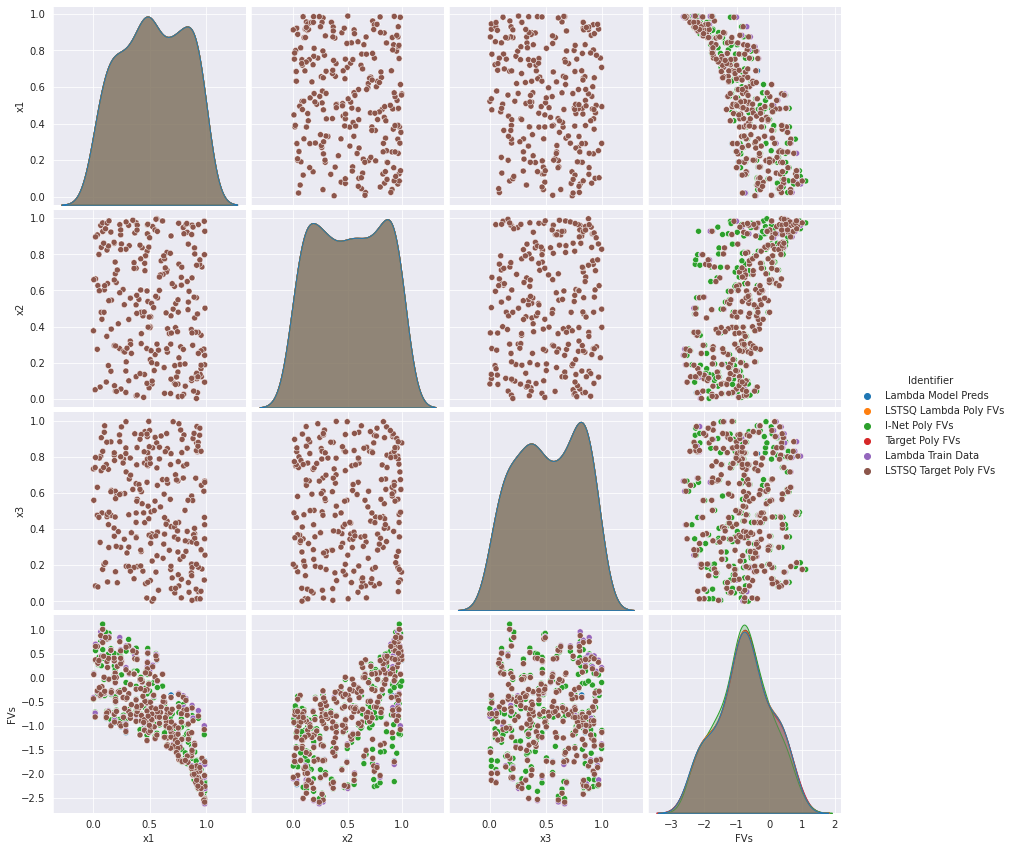

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.009423457834881991 | 0.999800893923566  |   -    |           1.3436*a**1.0*b**1.0*c**1.0 -            |
|            vs.            |                      |                    |        |           3.6354*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.9149*a**1.0*b**1.0*c**3.0 - 0.9677*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 1.0305*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

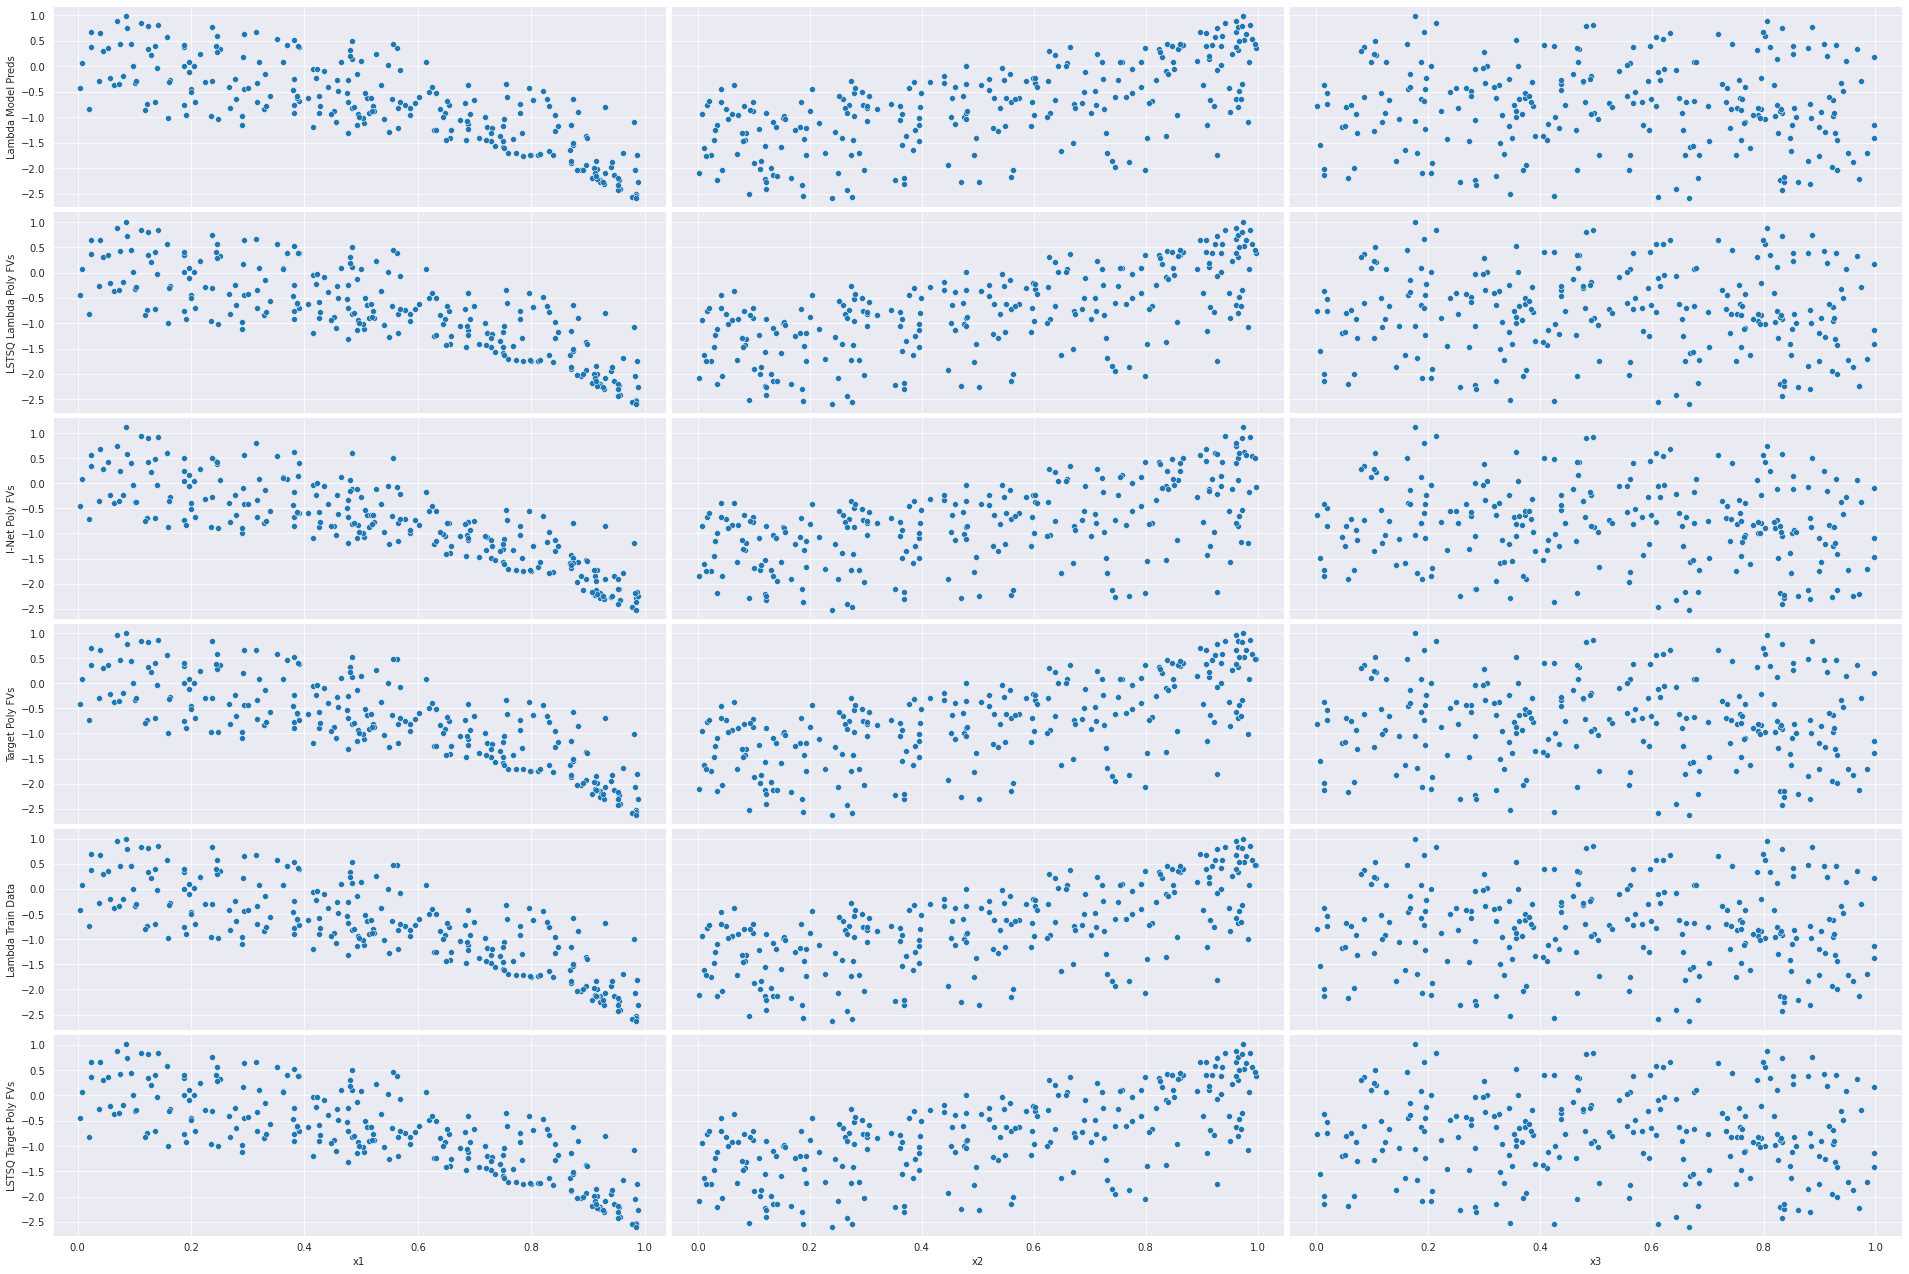

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.009423457834881991 | 0.999800893923566  |   -    |           1.3436*a**1.0*b**1.0*c**1.0 -            |
|            vs.            |                      |                    |        |           3.6354*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 0.9149*a**1.0*b**1.0*c**3.0 - 0.9677*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 1.0305*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0056


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 9.8975


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.0035


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()